# Knowledge Distillation Example

This notebook demonstrates how to use the knowledge distillation technique to train a student model to mimic a teacher model. The teacher is a larger convolutional neural network while the student is a simple DNN with only 2 fully connected layers.

In [1]:
%%bash
pip install torchmetrics
pip install torchview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 13.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchmetrics import Accuracy
from torchview import draw_graph
from tqdm.auto import tqdm, trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

# Define datasets
datasets_kwargs = {'download': True, 'transform': transform}
train_dataset = datasets.MNIST('data/', train=True, **datasets_kwargs)
test_dataset = datasets.MNIST('data/', train=False, **datasets_kwargs)

# Define dataloaders
dataloader_kwargs = {'batch_size': 256, 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 170735128.92it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 99946942.10it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31489401.97it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21922357.62it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# Specify the models
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 28x28x1 -> 28x28x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 28x28x16 -> 28x28x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # 28x28x32 -> 28x28x64

        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.LazyLinear(10)

        self.pool = nn.MaxPool2d(2, 2)  # 28x28x64 -> 14x14x64

    def forward(self, x, temperature=1.0):
        # Convolutional layers
        x = F.gelu(self.conv1(x))  # 28x28x1 -> 28x28x16
        x = self.pool(F.gelu(self.conv2(x)))  # 28x28x16 -> 14x14x32
        x = self.pool(F.gelu(self.conv3(x)))  # 14x14x32 -> 7x7x64

        # Fully connected layers
        x = torch.flatten(x, 1)
        x = F.gelu(self.fc1(x))  # 3136 -> 512
        x = self.fc2(x)  # 512 -> 10
        x /= temperature
        x = F.softmax(x, dim=1)  # 10 -> 10
        return x


class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 768)
        self.fc2 = nn.LazyLinear(10)

    def forward(self, x):
        # Fully connected layers
        x = torch.flatten(x, 1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


# Teacher Model Training

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

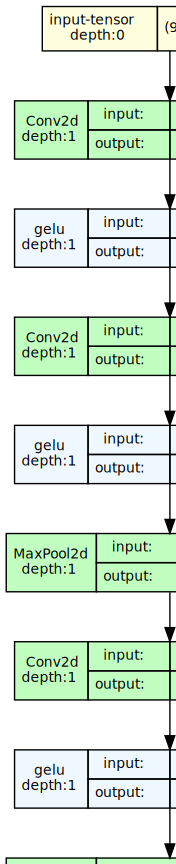

In [4]:
# Train the teacher like a normal model
teacher = Teacher().to(device)
teacher_optimizer = torch.optim.AdamW(teacher.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
n_epochs = 10
hist = []
best_epoch = 0
best_loss = float('inf')
iterator = trange(n_epochs)
for epoch in iterator:
    loss_i = 0.0
    for i, (x_train, y_train) in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        # Move data to device
        x_train, y_train = x_train.to(device), y_train.to(device)

        # Forward pass
        teacher_optimizer.zero_grad()
        y_hat = teacher.forward(x_train)
        loss = criterion(y_hat, y_train)

        # Backward pass
        loss.backward()
        teacher_optimizer.step()
        loss_i += loss.item()


# Model arch
display(draw_graph(teacher, input_size=x_train.shape, depth=1).visual_graph)

In [5]:
with torch.inference_mode():
    accuracy = Accuracy(task='multiclass', num_classes=10)
    for x_test, y_test in tqdm(test_loader, total=len(test_loader)):
        # Move data to device
        x_test, y_test = x_test.to(device), y_test.to(device)

        # Forward pass
        y_hat = teacher.forward(x_test)
        _, predicted = torch.max(y_hat.data, 1)
        accuracy(y_hat.cpu(), y_test.cpu())
    teacher_acc = accuracy.compute()
    print(f'Accuracy = {teacher_acc:.2%}')
    accuracy.reset()

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy = 99.08%


# Student Model Training

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

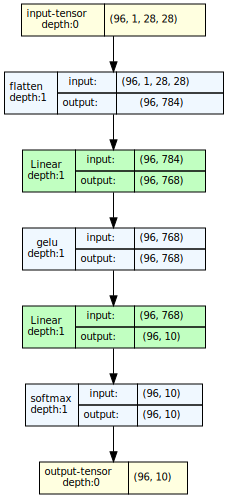

In [6]:
# Student model training
student = Student()
student.to(device)
student_optimizer = torch.optim.AdamW(student.parameters(), lr=1e-3)
student_criterion = nn.KLDivLoss(reduction='batchmean')

# Training loop
temp = 1.2
n_epochs = 20
iterator = trange(n_epochs)
for epoch in iterator:
    loss_i = 0.0
    accuracy = Accuracy(task='multiclass', num_classes=10)
    for i, (x_train, y_train) in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        # Move data to device
        x_train, y_train = x_train.to(device), y_train.to(device)

        # Forward pass
        student_optimizer.zero_grad()
        y_hat_teacher = teacher.forward(x_train, temperature=temp)
        y_hat_student = student.forward(x_train)
        loss = temp**2 * student_criterion(y_hat_student, y_hat_teacher)
        accuracy(y_hat_student.cpu(), y_train.cpu())

        # Backward pass
        loss.backward()
        student_optimizer.step()
        loss_i += loss.item()
    iterator.set_description(f'Epoch {epoch} | loss: {loss_i:.4f} | Accuracy: {accuracy.compute():.2%}')
    accuracy.reset()

# Model arch
display(draw_graph(student, input_size=x_train.shape, depth=1).visual_graph)

In [7]:
with torch.inference_mode():
    accuracy = Accuracy(task='multiclass', num_classes=10)
    for x_test, y_test in tqdm(test_loader, total=len(test_loader)):
        # Move data to device
        x_test, y_test = x_test.to(device), y_test.to(device)

        # Forward pass
        y_hat = student.forward(x_test)
        _, predicted = torch.max(y_hat.data, 1)
        accuracy(y_hat.cpu(), y_test.cpu())
    student_acc = accuracy.compute()
    print(f'Accuracy = {student_acc:.2%}')
    accuracy.reset()

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy = 97.87%


In [8]:
print(f'Compression ratio = {count_parameters(teacher) / count_parameters(student):.1f}:1')
print(f'    Teacher parameters = {count_parameters(teacher):,}')
print(f'    Student parameters = {count_parameters(student):,}')
print()
print(f'Teacher Accuracy = {teacher_acc:.2%}')
print(f'Student Accuracy = {student_acc:.2%}')

Compression ratio = 2.7:1
    Teacher parameters = 1,634,570
    Student parameters = 610,570

Teacher Accuracy = 99.08%
Student Accuracy = 97.87%
